# Time Budget Analysis

Script to generate time-budget analysis and visualize results from annotated mini-scenes.

Input: CSV file containing mini-scene id, track id, frame, and behavior label for each video

Outputs: 
- CSV file containing time budget analysis for each video
- Gantt charts visualizing behavior of individual animals overtime 

### Step 1: Create CSV file containing time-budget analysis for selected mini-scenes

In [35]:
# import libraries
import cv2
import pandas as pd
from lxml import etree
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:

# define directories for input and output
mini_scene_info = []
mini_scene_dir = 'data/mini-scenes'
output_path = 'data/time_budgets.csv'

# define behavior label to index mapping
label2number = {
    "Walk": 0,
    "Graze": 1,
    "Browse": 2,
    "Head Up": 3,
    "Auto-Groom": 4,
    "Trot": 5,
    "Run": 6,
    "Occluded": 7
    }

# select the video files to process
# list video id
video_names = [
    "18_01_2023_session_7|drone|DJI_0068",
    "18_01_2023_session_7|drone|DJI_0069",
    "18_01_2023_session_7|drone|DJI_0070",
    "18_01_2023_session_7|drone|DJI_0071",
 ]

In [3]:
# define methods to process the video files

def get_tracks_info(track_file: str) -> list[dict]:
    root = etree.parse(track_file).getroot()
    tracks = []
    for track in root.iterfind("track"):
        track_id = track.attrib["id"]
        track_species = track.attrib["label"]
        tracks.append({
            'id': track_id,
            'species' : track_species
            })
    return tracks

def get_mini_scene_time(mini_scene_dir: str, vid_name: str, mini_scene_id: str):
    mini_scene_video = f'{mini_scene_dir}/{vid_name}/{mini_scene_id}.mp4'
    vid_cap = cv2.VideoCapture(mini_scene_video)
    fps = vid_cap.get(cv2.CAP_PROP_FPS)
    frame_count = vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)
    vid_cap.release()
    return frame_count / fps

def get_mini_scene_percent(vid_name: str, scene_id: int):
    mini_scene = pd.read_csv(f"mini_scene_behavior_annotations/{vid_name.split('|')[-1]}_annotations.csv", sep=' ', encoding='utf-8', index_col=False)
    indiv_data = mini_scene.query(f"track == {scene_id}")
    total = indiv_data.shape[0]
    walk = indiv_data.query(f"label == {label2number['Walk']}").shape[0]
    head_up = indiv_data.query(f"label == {label2number['Head Up']}").shape[0]
    graze = indiv_data.query(f"label == {label2number['Graze']}").shape[0]
    
    return {
        'Walk': walk / total,
        'Head Up': head_up / total,
        'Graze': graze / total,
        'Other': (total - (walk + head_up + graze)) / total
    }

def get_mini_scene_info(mini_scene_info: list, track_info: list, mini_scene_dir: str, vid_name: str):
    for track in track_info:
        mini_scene_id = track['id']
        mini_scene_species = track['species']
        mini_scene_interval = get_mini_scene_time(mini_scene_dir, vid_name, mini_scene_id)
        mini_scene_percent = get_mini_scene_percent(vid_name, int(mini_scene_id))
        
        mini_scene_info.append({
            'video_id' : vid_name,
            'mini_scene_id' : f'{vid_name}_{mini_scene_id}',
            'Walk' : mini_scene_percent['Walk'],
            'Head Up' : mini_scene_percent['Head Up'],
            'Graze' : mini_scene_percent['Graze'],
            'Other' : mini_scene_percent['Other'],
            'Interval (sec)' : mini_scene_interval,
            'Habitat' : '0',
            'Count of Individuals' : -1,
            'Species' : mini_scene_species
            })

In [ ]:
# process the video files
# get mini scene info
for vid_name in tqdm(video_names, desc='video'):
    track_file = f"{mini_scene_dir}/{vid_name}/metadata/{vid_name.split('|')[-1]}_tracks.xml"
    track_info = get_tracks_info(track_file)
    get_mini_scene_info(mini_scene_info, track_info, mini_scene_dir, vid_name)
    
# save the mini scene info to a csv file
pd.DataFrame(mini_scene_info).to_csv(output_path, index=False)

### Step 2: Visualize time-budgets

### Whole Session

In [15]:
# import the csv file containing the time budgets
time_budgets = pd.read_csv(output_path)
time_budgets.head()

,video_id,mini_scene_id,Walk,Head Up,Graze,Other,Interval (sec),Habit,Count of Individuals,Species
0,18_01_2023_session_7|drone|DJI_0068,18_01_2023_session_7|drone|DJI_0068_0,0.860073,0.060114,0.032088,0.047725,162.729396,0,2,Grevy
1,18_01_2023_session_7|drone|DJI_0068,18_01_2023_session_7|drone|DJI_0068_1,0.986596,0.003656,0.000000,0.009748,164.297631,0,2,Grevy
2,18_01_2023_session_7|drone|DJI_0069,18_01_2023_session_7|drone|DJI_0069_0,0.777033,0.165034,0.009971,0.047963,194.094094,0,2,Grevy
3,18_01_2023_session_7|drone|DJI_0069,18_01_2023_session_7|drone|DJI_0069_1,0.726147,0.273509,0.000344,0.000000,194.094094,0,2,Grevy
4,18_01_2023_session_7|drone|DJI_0070,18_01_2023_session_7|drone|DJI_0070_0,0.673375,0.307706,0.000000,0.018920,193.993994,0,2,Grevy


In [16]:
# create column for each animal id
time_budgets['Animal ID'] = time_budgets['mini_scene_id'].str.split('_').str[-1]
time_budgets = time_budgets[['Animal ID', 'Walk', 'Head Up', 'Graze', 'Other']]
time_budgets.head()

,Animal ID,Walk,Head Up,Graze,Other
0,0,0.860073,0.060114,0.032088,0.047725
1,1,0.986596,0.003656,0.000000,0.009748
2,0,0.777033,0.165034,0.009971,0.047963
3,1,0.726147,0.273509,0.000344,0.000000
4,0,0.673375,0.307706,0.000000,0.018920


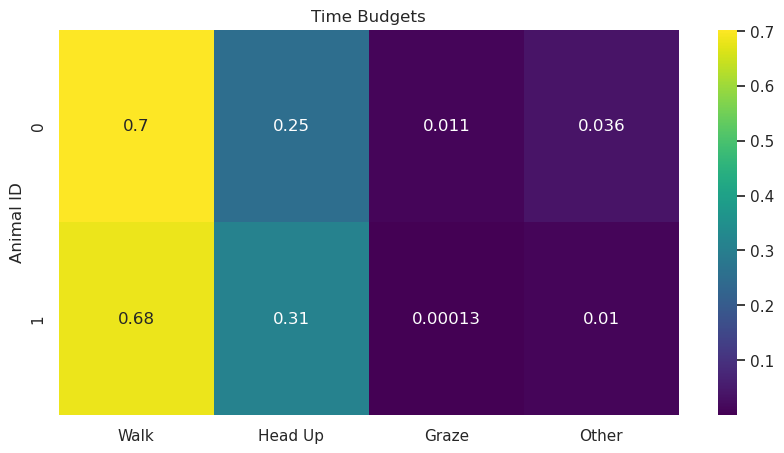

In [32]:
# plot the time budgets for each animal

# create dataframe for each animal
animal_id = time_budgets['Animal ID'].unique()
animal_time_budgets = []
for animal in animal_id:
    animal_data = time_budgets.query(f"`Animal ID` == '{animal}'")
    animal_time_budgets.append({
        'Animal ID' : animal,
        'Walk' : animal_data['Walk'].mean(),
        'Head Up' : animal_data['Head Up'].mean(),
        'Graze' : animal_data['Graze'].mean(),
        'Other' : animal_data['Other'].mean()
    })

animal_time_budgets = pd.DataFrame(animal_time_budgets)

# print the time budgets color coded by percentage
plt.figure(figsize=(10, 5))
sns.heatmap(animal_time_budgets.set_index('Animal ID'), cmap='viridis', annot=True)
plt.title('Time Budgets')
plt.show()

### Individual Gantt Chart

In [49]:
# import the csv file containing behavior data for an individual
individual_data = pd.read_csv('/fs/ess/PAS2136/Kenya-2023/Zebras/methods_paper_analysis/annotation_process/kabr-tools/data/mini_scene_behavior_annotations/DJI_0068_annotations.csv', sep=' ', encoding='utf-8', index_col=False)

# get the time budget of an individual, labeled as 0
individual_data = individual_data.query('track == 0')

# create column for time from frame number
individual_data['time'] = individual_data['frame'] / 30

# create behavior labels with label2number mapping
individual_data['behavior'] = individual_data['label'].map({v: k for k, v in label2number.items()})

# create dict of behaviors in focal and drone
behaviors = individual_data['behavior'].unique()
behaviors = {b: i for i,b in enumerate(behaviors)}


In [68]:
# get all the csv files in the directory
csv_files = [f for f in os.listdir('data/mini_scene_behavior_annotations/') if f.endswith('.csv')]
csv_files = ['DJI_0069_annotations.csv']

# create a dataframe containing all csv files
all_data = []
for f in csv_files:
    data = pd.read_csv(f'data/mini_scene_behavior_annotations/{f}', sep=' ', encoding='utf-8', index_col=False)
    data['video'] = f.split('_')[0]
    all_data.append(data)

all_data = pd.concat(all_data)

# create column for time from frame number
all_data['time'] = all_data['frame'] / 30

# create behavior labels with label2number mapping
all_data['behavior'] = all_data['label'].map({v: k for k, v in label2number.items()})

# create dict of behaviors 
behaviors = all_data['behavior'].unique()
behaviors = {b: i for i,b in enumerate(behaviors)}

# create dataframe for each animal
zebra_0 = all_data.query('track == 0')
zebra_1 = all_data.query('track == 1')

# drop all columns except time and behavior
zebra_0 = zebra_0[['time', 'behavior']]
zebra_1 = zebra_1[['time', 'behavior']]

In [70]:
# get the start and end times for each behavior duration
def get_start_end_times(df):
    times = []
    for i in range(len(df)):
        if i == 0:
            start_behavior = df.iloc[i]['behavior']
            start_times = df.iloc[i]['time']
            times.append([start_behavior, start_times, 0])
        elif df.iloc[i]['behavior'] != df.iloc[i-1]['behavior']:
            end_behavior = df.iloc[i-1]['behavior']
            end_times = df.iloc[i-1]['time']
            times[-1][2] = end_times # update end time of previous behavior
            
            behavior = df.iloc[i]['behavior'] # start new behavior
            start_times = df.iloc[i]['time'] # start new behavior
            times.append([behavior, start_times, 0]) 
        # handle last behavior
        if i == len(df)-1:
            end_behavior = df.iloc[i]['behavior']
            end_times = df.iloc[i]['time']
            times[-1][2] = end_times
    return times 

# get the start and end times for each behavior duration
zebra_0_times = get_start_end_times(zebra_0)
zebra_1_times = get_start_end_times(zebra_1)

# create a dataframe for each behavior duration
zebra_0_times = pd.DataFrame(zebra_0_times, columns=['behavior', 'start', 'end'])
zebra_1_times = pd.DataFrame(zebra_1_times, columns=['behavior', 'start', 'end'])

In [72]:
# get the start and end times for each behavior duration
def get_start_end_times(df):
    times = []
    for i in range(len(df)):
        if i == 0:
            start_behavior = df.iloc[i]['behavior']
            start_times = df.iloc[i]['time']
            times.append([start_behavior, start_times, 0])
        elif df.iloc[i]['behavior'] != df.iloc[i-1]['behavior']:
            end_behavior = df.iloc[i-1]['behavior']
            end_times = df.iloc[i-1]['time']
            times[-1][2] = end_times # update end time of previous behavior
            
            behavior = df.iloc[i]['behavior'] # start new behavior
            start_times = df.iloc[i]['time'] # start new behavior
            times.append([behavior, start_times, 0]) 
        # handle last behavior
        if i == len(df)-1:
            end_behavior = df.iloc[i]['behavior']
            end_times = df.iloc[i]['time']
            times[-1][2] = end_times
    return times 


times = pd.DataFrame(columns=['behavior','start', 'end'])
zebra_0_times = get_start_end_times(zebra_0)
zebra_1_times = get_start_end_times(zebra_1)

# convert to dataframe
zebra_0_times = pd.DataFrame(zebra_0_times, columns=['behavior','start', 'end'])
zebra_1_times = pd.DataFrame(zebra_1_times, columns=['behavior','start', 'end'])

# convert to datetime
zebra_0_times['start'] = pd.to_datetime(zebra_0_times['start'], unit='s')
zebra_0_times['end'] = pd.to_datetime(zebra_0_times['end'], unit='s')
zebra_1_times['start'] = pd.to_datetime(zebra_1_times['start'], unit='s')
zebra_1_times['end'] = pd.to_datetime(zebra_1_times['end'], unit='s')


# calculate the duration of each behavior and relative start time
def calculate_duration(df):
    df['duration'] = df['end'] - df['start']
    # convert to seconds
    df['duration'] = df['duration'].dt.total_seconds()
    
    df['rel_start'] = df['start'] - df['start'].iloc[0]
    df['rel_start'] = df['rel_start'].dt.total_seconds()
    return df

zebra_0_times = calculate_duration(zebra_0_times)
zebra_1_times = calculate_duration(zebra_1_times)

In [84]:
ethogram = ['Head Up','Graze','Walk','Trot', 'Run', 'Defecating','Auto-Groom','Fighting','Sniff','Drink','Mutual Grooming',
            'Occluded','Out of sight','Out of Focus','Out of Frame', 'No data']
invalid_ethogram = ['Occluded','Out of sight','Out of Focus','Out of Frame', 'No data']
colors = dict(zip(ethogram, plt.cm.tab20.colors[:len(ethogram)]))

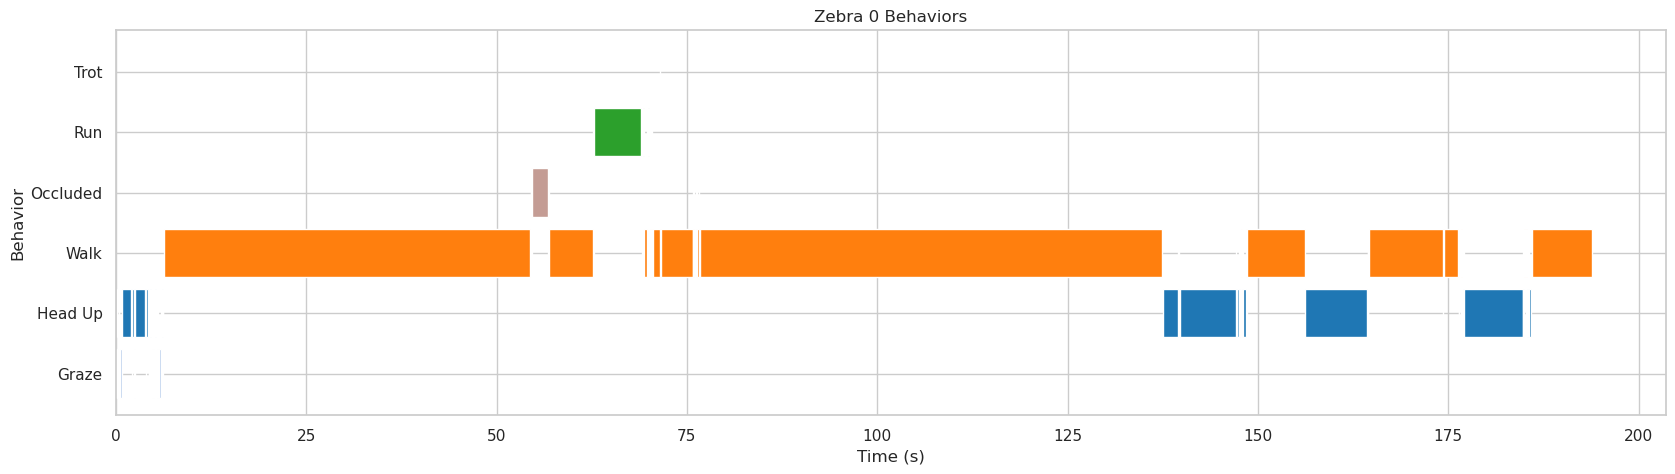

In [87]:
# plot the gantt chart for zebra 0
fig, ax = plt.subplots(figsize=(20, 5))
ax.barh(zebra_0_times['behavior'], zebra_0_times['duration'], left=zebra_0_times['rel_start'], color=[colors[b] for b in zebra_0_times['behavior']])
ax.set(title='Zebra 0 Behaviors', ylabel='Behavior', xlabel='Time (s)')
plt.show()


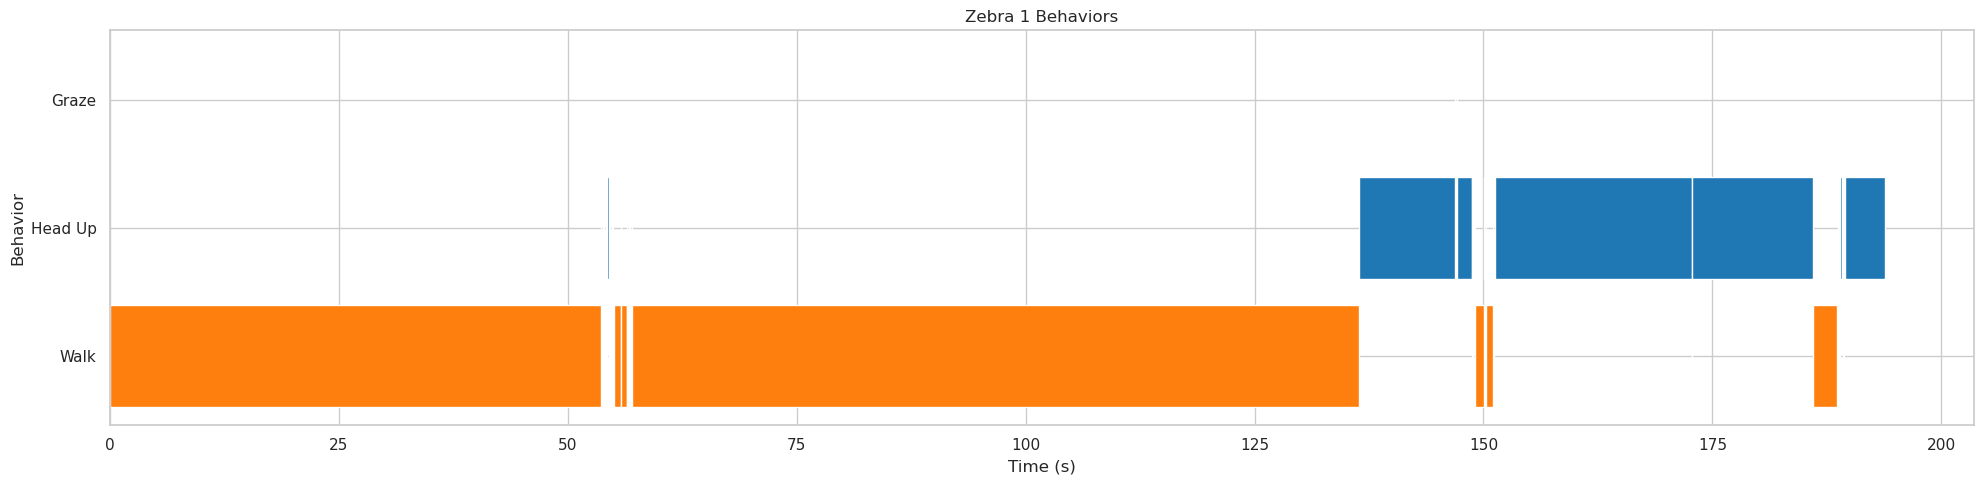

In [88]:
# plot the gantt chart
fig, ax = plt.subplots(figsize=(20, 5))
ax.barh(y=zebra_1_times['behavior'], width=zebra_1_times['duration'], left=zebra_1_times['rel_start'], color=zebra_1_times['behavior'].map(colors))
ax.set(title='Zebra 1 Behaviors', ylabel='Behavior', xlabel='Time (s)')
plt.tight_layout()